# This notebook shows the dataset preprocessing
- input normalization
- output scaling

In [1]:
import gcsfs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

## [1] Load dataset

In [2]:
fs = gcsfs.GCSFileSystem()
print(fs.ls("gs://leap-persistent-ro/sungdukyu"))
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
ds_train_in = xr.open_dataset(mapper, engine='zarr', chunks={})
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds_train_out = xr.open_dataset(mapper, engine='zarr', chunks={})

# grid info
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
ds_grid = xr.open_dataset(mapper, engine='zarr')

# #<Saving toy dataset>
# ds_train_in.isel(sample=slice(0,4)).to_zarr('./toy_dataset/E3SM-MMF_ne4.train.input.tiny.zarr')
# ds_train_out.isel(sample=slice(0,4)).to_zarr('./toy_dataset/E3SM-MMF_ne4.train.output.tiny.zarr')

['leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr', 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr', 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr', 'leap-persistent-ro/sungdukyu/testing']


## [2] Determine in/out variables; subsampling

In [3]:
# in/out variable lists (these are subset of dataset variables)
vars_mli = ['state_t','state_q0001','state_ps','pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX']

vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC',
            'cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']

In [4]:
# select ML variables
# note that otuput variables are tendencies, not state (for t and q)
mli = ds_train_in[vars_mli]
mlo = ds_train_out
mlo['ptend_t']     = (mlo['state_t'] - mli['state_t'])/1200 # T tendency [K/s]
mlo['ptend_q0001'] = (mlo['state_q0001'] - mli['state_q0001'])/1200 # Q tendency [kg/kg/s]
mlo = mlo[vars_mlo] 

In [5]:
# # sub sampling dataset for tutorial purpose only
# if True: 
#     stride = 701
#     mli = mli.isel(sample=slice(0,None,stride))
#     mlo = mlo.isel(sample=slice(0,None,stride))
# mli['sample'].__len__()

In [6]:
mli.state_q0001.isel(sample = 100, ncol = 223).values

array([1.48429132e-06, 1.44823550e-06, 1.40296176e-06, 1.36099057e-06,
       1.25513485e-06, 1.13919366e-06, 1.04444080e-06, 9.76207620e-07,
       9.23818046e-07, 8.72516835e-07, 8.51363407e-07, 8.65974661e-07,
       9.14723148e-07, 9.93850224e-07, 1.01703125e-06, 1.03102484e-06,
       1.04628954e-06, 1.05023647e-06, 1.47519171e-06, 2.38285926e-06,
       3.80775234e-06, 6.93561059e-06, 1.85997251e-05, 2.65687936e-05,
       3.70240971e-05, 6.18745984e-05, 9.30469998e-05, 1.69559670e-04,
       2.84469192e-04, 4.75111444e-04, 6.98064489e-04, 1.11391777e-03,
       1.54630371e-03, 1.76706235e-03, 1.96381038e-03, 2.19042054e-03,
       2.73983458e-03, 3.44186145e-03, 4.73395982e-03, 6.01049195e-03,
       7.26889047e-03, 7.89425379e-03, 8.68090920e-03, 9.33953974e-03,
       9.96468034e-03, 1.08921253e-02, 1.14270858e-02, 1.16344879e-02,
       1.17559527e-02, 1.18782860e-02, 1.20208282e-02, 1.20963463e-02,
       1.21814572e-02, 1.22757622e-02, 1.25383245e-02, 1.28179199e-02,
      

In [7]:
mlo.ptend_q0001.isel(sample = 100, ncol = 223).values

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.36107782e-17,  3.41963259e-18, -1.07300475e-17,  1.85824753e-15,
       -1.52180074e-14,  6.84827273e-13,  1.43801713e-11, -5.48309285e-12,
       -5.02357476e-11,  6.10730018e-11,  1.17606215e-10,  1.24222272e-10,
        7.55572547e-11,  1.56137637e-09,  1.33441640e-09, -1.86657614e-09,
        6.97626443e-10,  4.77428863e-10,  6.42281240e-09,  8.97957069e-09,
        2.58219522e-09,  9.16184867e-11,  4.99910058e-09,  3.74925838e-09,
       -9.83080213e-10,  1.48927517e-08,  1.72762199e-08, -3.16859532e-09,
        6.86920844e-09, -3.25754972e-08,  2.29429289e-08, -1.45946841e-08,
        1.75394497e-09,  6.36816458e-09,  1.01736324e-08,  1.39899386e-08,
        7.61889239e-09, -5.39993925e-09, -1.22307879e-08, -1.28742479e-08,
       -1.32886506e-08,  

Now, we only have 1/701 of total samples, that is only 300.\
However, for the real use for ML, subsampling should be kept at minimum or not used at all.

### [3] Input / output normalization
We want to calculate summary statistics for normalizing ML inputs, e.g., mean, min, and max.\
In the dataset, the dimension of a variable can be:
- 2D, e.g., pbuf_SOLIN = pbuf_SOLIN(sample, ncol)
- 3D, e.g., state_T = state_t(sample, lev, ncol)

We will calculate summary statistics through only sample and ncol dimensions.


In [8]:
mli_mean = mli.mean(dim=['sample', 'ncol'])
mli_min  = mli.min(dim=['sample', 'ncol'])
mli_max  = mli.max(dim=['sample', 'ncol'])
mli_std  = mli.std(dim=['sample', 'ncol'])

now see that the calculated stastic is either a scalar or a 1-D array, depending on the dimension of the original variable.

In [9]:
mli_mean['pbuf_SOLIN'].values

array(340.51651384)

In [10]:
# # Processing vertically-resolved variables (e.g., state_t, state_q0001) takes longer than processing surface variables, e.g., pbuf_SOLIN.
# mli_mean['state_t'].values

save the calculated statistics to netcdf files

In [11]:
if False:
    mli_mean.to_netcdf('./norm_factors/mli_mean.tutorial.nc') # i changed the file name to avoid accidental overwriting of the original files
    mli_min.to_netcdf('./norm_factors/mli_min.tutorial.nc')
    mli_max.to_netcdf('./norm_factors/mli_max.tutorial.nc')
    mli_std.to_netcdf('./norm_factors/mli_std.tutorial.nc')
else:
    mli_mean = xr.open_dataset('./norm_factors/mli_mean.nc')
    mli_min  = xr.open_dataset('./norm_factors/mli_min.nc')
    mli_max  = xr.open_dataset('./norm_factors/mli_max.nc')
    mli_std  = xr.open_dataset('./norm_factors/mli_std.nc')

KeyError: 'state_ps'

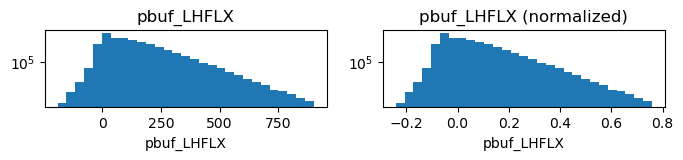

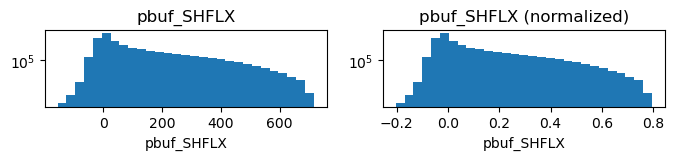

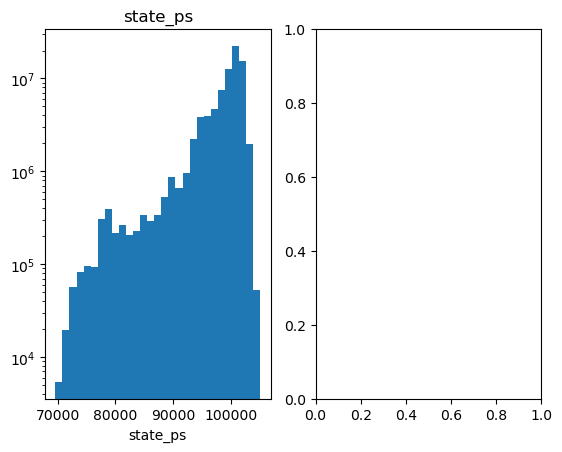

In [12]:
# # before and after input norm
# # pbuf_COSZRS, pbuf_LHFLX, pbuf_SHFLX, pbuf_SOLIN, pbuf_TAUX, pbuf_TAUY, state_ps
# # state_q0001, state_q0002, state_q0003, state_t, state_u, state_v, state_pmid
# for kvar in ['pbuf_LHFLX', 'pbuf_SHFLX', 'state_ps', 'pbuf_SOLIN']:
#     fig, ax_ = plt.subplots(ncols=2)
#     ax = ax_[0]
#     mli[kvar].plot.hist(bins=29,ax=ax)
#     ax.set_title(kvar)
#     ax.set_yscale('log')
#     ax = ax_[1]
#     ((mli[kvar] - mli_mean[kvar])/(mli_max[kvar] - mli_min[kvar])).plot.hist(bins=29,ax=ax)
#     ax.set_title(f'{kvar} (normalized)')
#     ax.set_yscale('log')
#     fig.set_size_inches(8,1)
    


Now time to scale output variables!\
for ptend_t and ptend_q0001, are converted common energy unit, e.g.,\
- ptend_t * cp  [W/m2]
- ptend_q * (lv+lf)  [w/m2]

They have comparable scale (with some physical reasons).\
For the rest of variables, matching scale to the above two.\
Why do this? to make optimizer feel every variables

In [18]:
mlo

<xarray.Dataset>
Dimensions:         (sample: 210240, lev: 60, ncol: 384)
Dimensions without coordinates: sample, lev, ncol
Data variables:
    ptend_t         (sample, lev, ncol) float64 dask.array<chunksize=(1512, 60, 384), meta=np.ndarray>
    ptend_q0001     (sample, lev, ncol) float64 dask.array<chunksize=(1512, 60, 384), meta=np.ndarray>
    cam_out_NETSW   (sample, ncol) float64 dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_FLWDS   (sample, ncol) float64 dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_PRECSC  (sample, ncol) float64 dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_PRECC   (sample, ncol) float64 dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_SOLS    (sample, ncol) float64 dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_SOLL    (sample, ncol) float64 dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_SOLSD   (sample, ncol) float64 dask.array<chunksize=(1512, 384), meta=np.ndarray>
    cam_out_SOLLD   (sample, ncol) float64 dask.array<chunksize=(1512, 384), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [13]:
if True:
    mlo_scale = xr.Dataset({'ptend_t':        ('lev', 1.00464e3 * np.ones(mlo.dims['lev'])), # J/K/kg
                            'ptend_q0001':    ('lev', (2.501e6 + 3.337e5)*np.ones(mlo.dims['lev'])), # J/kg
                            'cam_out_NETSW':  1e-2 *0.24,
                            'cam_out_FLWDS':  1e-2 *.5,
                            'cam_out_PRECSC': 17280000 * .72,
                            'cam_out_PRECC':  1728000 * .76,
                            'cam_out_SOLS':   1e-2 * .5,
                            'cam_out_SOLL':   1e-2 * .46,
                            'cam_out_SOLSD':  1e-2 * .61,
                            'cam_out_SOLLD':  1e-2 * .95
                           })
    mlo_scale.to_netcdf('./norm_factors/mlo_scale.tutorial.nc') # i changed the file name to avoid accidental overwriting of the original files
else:
    mlo_scale = xr.open_dataset('./norm_factors/mlo_scale.nc')

In [20]:
mlo_scale.ptend_q0001.shape,mlo.ptend_q0001.shape

((60,), (210240, 60, 384))

In [21]:
(mlo_scale.ptend_q0001 *mlo.ptend_q0001).shape

(60, 210240, 384)

In [14]:
# # before and after output scaling
# for kvar in ['cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL']:
#     fig, ax_ = plt.subplots(ncols=2)
#     ax = ax_[0]
#     mlo[kvar].plot.hist(bins=29,ax=ax)
#     ax.set_title(kvar)
#     ax.set_yscale('log')
#     fig.set_size_inches(8,1.5)
#     ax = ax_[1]
#     (mlo[kvar]*mlo_scale[kvar]).plot.hist(bins=29,ax=ax)
#     ax.set_title(kvar)
#     ax.set_yscale('log')
#     fig.set_size_inches(8,1)

KeyboardInterrupt: 

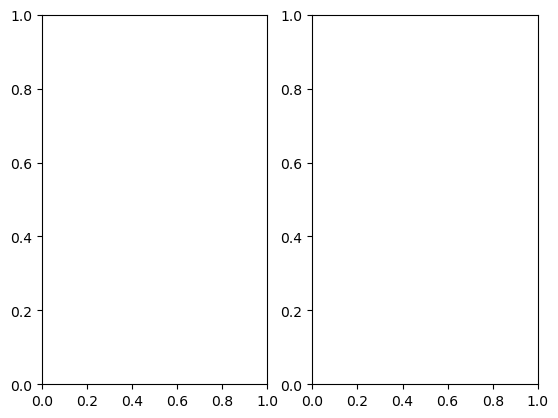

In [16]:
 # again, processing vertical-resolved variables takes longer.
 for kvar in ['ptend_q0001']:
     fig, ax_ = plt.subplots(ncols=2)
     ax = ax_[0]
     mlo[kvar].plot.hist(bins=29,ax=ax)
     ax.set_title(kvar)
     ax.set_yscale('log')
     ax = ax_[1]
     (mlo[kvar]*mlo_scale[kvar]).plot.hist(bins=29,ax=ax)
     ax.set_title(kvar)
     ax.set_yscale('log')
     fig.set_size_inches(8,1.5)